In [1]:
# Učitaj osnovne biblioteke...
import scipy as sp
import sklearn
import itertools
import cv2
import numpy as np

import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [68]:
def preprocess_image(image, max_width=640, max_height = 480):
    factor = 1
    if image.shape[0]>max_height:
        factor = max_height/float(image.shape[0])
    if image.shape[1]>max_width:
        f2 = max_width/float(image.shape[1])
        factor = f2 if f2 <factor else factor
    print 'factor',factor
    resized = cv2.resize(image,(0,0),fx=factor,fy=factor,interpolation=cv2.INTER_CUBIC) if factor <1 else image
    gray = cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)
    return resized,gray

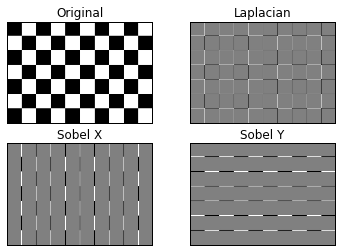

In [69]:
# bgr_image = cv2.imread('../data/train/nd1.jpg')
# gray = cv2.cvtColor(bgr_image,cv2.COLOR_BGR2GRAY)
# gray= cv2.GaussianBlur(gray,sigmaX=0,ksize=(5,5))
# plt.figure(figsize=(20,20))
# plt.imshow(gray, cmap='gray')
# plt.figure(figsize=(20,20))

img = cv2.imread('../data/misc/raster.jpg',0)

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()
#gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,9,2)
#plt.imshow(gray, cmap='gray')


In [70]:
def find_best_k(harris_output, desired_feature_count,propose_k=0.1, tolerance = 0.1):
    min_k = 0
    k = propose_k
    max_k = 1
    max_val = harris_output.max()
    while True:
        feature_count = np.sum(harris_output>k*max_val)
        
        #print min_k,k,max_k,feature_count
        if feature_count> desired_feature_count*(1+tolerance):
            min_k = k
        elif feature_count < desired_feature_count*(1-tolerance) :
            max_k = k
        else:
            break
        if max_k-min_k < 0.001:
            break
        k = (max_k + min_k) /2
    return k


(448, 640)


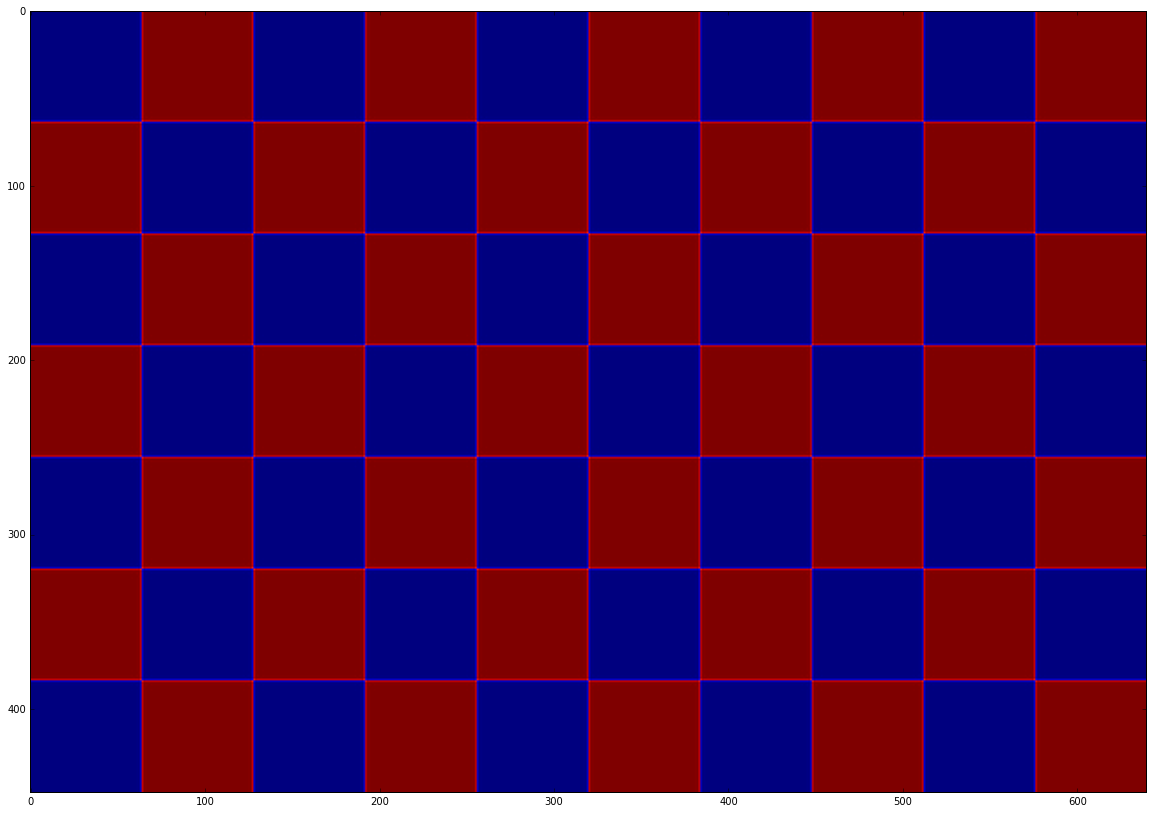

In [71]:
import cv2
import numpy as np

filename = '../data/test/nd2.jpg'
#filename = '../data/train/nd1.jpg'


print img.shape
plt.figure(figsize=(20,20))
plt.imshow(img)

In [72]:

def symmetry_score_for_pixel(scan_line, index, width, kernel):
    left = scan_line[index-width:index].astype(float)
    right = np.flipud(scan_line[index:index+width]).astype(float)
    diff = np.abs(left - right)
    return diff.dot(kernel)

In [73]:
def unique_rows(a):
    order = np.lexsort(a.T)
    a = a[order]
    diff = np.diff(a, axis=0)
    ui = np.ones(len(a), 'bool')
    ui[1:] = (diff != 0).any(axis=1) 
    return a[ui]

def process_feature(gray_image,width,index,scan_line):
    left = scan_line[index-width:index].astype(float)
    right = np.flipud(scan_line[index:index+width]).astype(float)
    avg_line = (left + right)/2
    raw =  (avg_line<np.average(avg_line)).astype(float)
    return sp.ndimage.interpolation.zoom(raw, 128/float(width), order=3,mode='constant')

In [93]:
X_train = []
y_train = []

filenames = [
    'nd1.jpg',
    'marc1.jpg',
    'eifel1.jpg',
    'angle.jpg',
    'angle2.jpg',
    'angle3.jpg',
    'angle4.jpg',
    'angle5.jpg',
    'tor_700p.jpg',
    'ne_notredame.jpg'
]
from random import shuffle
def get_features_for_file(filename):
    img = cv2.imread(filename)

    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    resized, gray = preprocess_image(img)

    gray = cv2.GaussianBlur(gray,sigmaX=0,ksize=(3,3))
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    #print resized.shape,gray.shape

    k = find_best_k(dst,1000)

    x = np.arange(0, gray.shape[1])
    y = np.arange(0,gray.shape[0])
    xx, yy = meshgrid(x, y)
    indices_all = np.dstack(meshgrid(x, y))

    #canny = cv2.Canny(gray,100,156)
    #gray = cv2.GaussianBlur(canny,sigmaX=0,ksize=(5,5))
    #print gray
    #print indices.shape
    indices = indices_all[dst>k*dst.max()]
    features = []
    for x,y in indices:
        for w in np.logspace(3,7,9,base=2).astype(np.int):
            if gray.shape[1] -x <w or x<w:
                continue
            scan_line = gray[y,:]
            val = symmetry_score_for_pixel(scan_line,x,w,np.ones(w)/w)
            if val<16:
                features.append(process_feature(gray,w,x,scan_line))
    for x,y in indices:
        cv2.circle(gray,(x,y),10,255)
    #plt.figure(figsize=(20,20)),plt.imshow(gray, cmap='gray'),plt.show()
    features=  list(unique_rows(np.array(features)))
    shuffle(features)
    features = np.array(features[:200])
    return features

cnt = 0
for filename in filenames:
    print filename
    filename = '../data/train/'+filename
    features = get_features_for_file(filename)
    X_train+=list(features)
    print features.shape
    y_train+=list(np.ones(features.shape[0])*cnt)
    cnt+=1

X_train = np.array(X_train)
y_train = np.array(y_train)


nd1.jpg
factor 0.8
(143, 128)
marc1.jpg
factor 0.8
(179, 128)
eifel1.jpg
factor 0.831168831169
(200, 128)
angle.jpg
factor 0.3125
(200, 128)
angle2.jpg
factor 0.3125
(200, 128)
angle3.jpg
factor 0.3125
(200, 128)
angle4.jpg
factor 0.3125
(200, 128)
angle5.jpg
factor 0.3125
(179, 128)
tor_700p.jpg
factor 0.914285714286
(200, 128)
ne_notredame.jpg
factor 0.36036036036
(190, 128)


In [94]:

from sklearn.neighbors import KNeighborsClassifier

NEIGHBOUR_COUNT = 2
neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=NEIGHBOUR_COUNT,weights='distance')
neigh.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=2, p=2, weights='distance')

In [97]:
filename = 'tor2.jpg'
for filename in ['nd2.jpg','marc2.jpg','eifel2.jpg','tor2.jpg','tor3.jpg','tor4.jpg','tor5.jpg']:
    X_test = get_features_for_file('../data/test/'+filename)
    pp =neigh.predict_proba(X_test)
    chances = np.zeros(len(filenames))
    for p in pp:
        if np.max(p)>0.5:
            chances[np.argmax(p)]+=1000.0/len(X_train[y_train==np.argmax(p)])
    print
    print "for: ",filename
    print chances
    print filenames[np.argmax(chances)]
    print filenames[int(sp.stats.mstats.mode(neigh.predict(X_test))[0][0])]

factor 0.8

for:  nd2.jpg
[  97.9020979    78.2122905    60.           55.          145.           40.
   45.          106.1452514    35.           57.89473684]
angle2.jpg
angle2.jpg
factor 0.757097791798

for:  marc2.jpg
[  41.95804196  195.53072626   25.           25.           25.           30.
   15.           33.51955307   45.           36.84210526]
marc1.jpg
marc1.jpg
factor 0.500521376434

for:  eifel2.jpg
[  83.91608392   44.69273743  100.          100.          105.           50.
   90.           55.86592179   75.           73.68421053]
angle2.jpg
angle.jpg
factor 0.333333333333

for:  tor2.jpg
[  20.97902098   16.75977654   65.           85.           85.           55.
   30.           22.34636872  240.          105.26315789]
tor_700p.jpg
tor_700p.jpg
factor 1

for:  tor3.jpg
[  20.97902098   16.75977654   10.           45.           60.           60.
    0.            5.58659218  245.          121.05263158]
tor_700p.jpg
tor_700p.jpg
factor 0.625

for:  tor4.jpg
[  27.9720279

In [ ]:


alpha = 1

distances, indices = neigh.kneighbors(X_test)

def predict(distances,indices,factor):
    classes = []
    for dists,inds in zip(distances,indices):
        if dists[1] > 0:
            fct =dists[0] / (dists[0]+ dists[1])
            if fct <factor:
                #print dists, inds[0],y_train[inds[0]]
                classes.append(y_train[inds[0]])
    return classes

def parse_classes(classes):
    md = scipy.stats.mstats.mode(classes)
    return int(md[0][0]),md[1][0]

print train_image_paths[parse_classes(predict(distances,indices,0.2))[0]]
print "===================================="

for factor in linspace(0.01,1,100):
    classes = predict(distances,indices,factor)
    mode, count = parse_classes(classes)
    print train_image_paths[mode], str(round(count/float(len(classes))*100))+"%", factor



y_pred = neigh.predict(X_test)
#print y_pred
pred_odds = neigh.predict_proba(X_test)


pred_odds[pred_odds<0.8] = 0
#pred_odds[pred_odds>=0.8] = 1

pred_odds = pred_odds[pred_odds.any(axis=1)]

In [ ]:
def symmetry_scores_on_line(whole_image, height_index=400, width = 100):
    scan_line = whole_image[height_index,:]
    kernel = cv2.getGaussianKernel(width*2,0)[width:]*2
    X = range(width,len(scan_line)-width)
    return np.squeeze(np.array([symmetry_score_for_pixel(scan_line,index,width,kernel) for index in X]))

In [ ]:
def symmetry_scores_map(image,width):#,verbose=False):
    img = np.zeros(image.shape[1] - width*2)
    for num in xrange(0,image.shape[0]):
        results = symmetry_scores_on_line(image,num,width)
        img = np.vstack((img,results))
    img = img.astype(np.float32)
    padding = np.zeros((img.shape[0],width))
    return np.hstack((padding,img,padding))[1:]#[:,w:img.shape[1]-w]


In [ ]:
sigmas = logspace(0,10,11,base=np.sqrt(2))
print sigmas

In [ ]:
bgr_image = cv2.imread('tor2.jpg')
bgr_image, gray_image = preprocess_image(bgr_image)

def pretty_show(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='gray')
    plt.show()

blured_gray_image = cv2.GaussianBlur(gray_image,sigmaX=0,ksize=(5,5)) 

width = 128
sym_map_horizontal = symmetry_scores_map(blured_gray_image,width)
#pretty_show(sym_map_horizontal)

#dog_maps_mult_horizontal = calculate_dog_maps_mult(sym_map_horizontal,sigmas)
sym_map_vertical = symmetry_scores_map(blured_gray_image.T,width)
#dog_maps_mult_vertical = calculate_dog_maps_mult(sym_map_vertical,sigmas)
pretty_show(bgr_image)
pretty_show(gray_image)

pretty_show(sym_map_horizontal)
pretty_show(sym_map_vertical.T)

#print sym_map_horizontal


#plt.figure(figsize=(20,20))
#plt.subplot(121),plt.imshow(sym_map_horizontal,cmap='gray')
#plt.subplot(122),plt.imshow(sym_map_vertical.T,cmap='gray')
#plt.show()

#sym_map_horizontal[sym_map_horizontal>25]=512
#sym_map_vertical[sym_map_vertical>25]=512



worst_case_h = np.max(sym_map_horizontal)

worst_case_v = np.max(sym_map_vertical)

suma_sumarum = (worst_case_h - sym_map_horizontal)*(worst_case_v-sym_map_vertical.T)
#suma_sumarum = (worst_case_v - sym_map_vertical.T)*(worst_case_v-sym_map_vertical.T)
#suma_sumarum = (worst_case_h - sym_map_horizontal)#*(worst_case_h-sym_map_horizontal)

suma_sumarum = suma_sumarum[width:-width,width:-width]
suma_sumarum_tw = np.max(suma_sumarum)- suma_sumarum

pretty_show(suma_sumarum_tw)

suma_sumarum_tw = suma_sumarum_tw.astype(np.float32)
kernel_size1= 16-1
gauss1= cv2.GaussianBlur(suma_sumarum_tw,sigmaX=0,ksize=(kernel_size1,kernel_size1)) 
kernel_size2= kernel_size1/2
gauss2= cv2.GaussianBlur(suma_sumarum_tw,sigmaX=0,ksize=(kernel_size2,kernel_size2)) 
suma_sumarum_tw =gauss1-gauss2# cv2.Sobel(suma_sumarum_tw,cv2.CV_32F,2,0,ksize=kernel_size)

#pretty_show(suma_sumarum)

print suma_sumarum_tw.shape

suma_sumarum_tw[suma_sumarum_tw<0] = 0
suma_sumarum_tw[suma_sumarum_tw<np.max(suma_sumarum_tw)*0.5] = 0

print suma_sumarum_tw.shape

neighborhood_size = 5
threshold = 0

data = suma_sumarum_tw

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))
#xy2 = []
#for y,x in xy:
#    if sym_map_horizontal[y+width,x+width]>60 and sym_map_vertical[x+width,y+width]>60:
#        xy2.append((y,x))
#xy = np.array(xy2)
#print xy
#plt.figure(figsize=(20,20))
#plt.subplot(121),plt.imshow(bgr_image,cmap='gray')
#plt.subplot(122)
#plt.scatter(xy[:, 1], xy[:, 0],marker='+',c='r')

#plt.imshow(suma_sumarum_tw,cmap='gray')
#plt.show()


plt.figure(figsize=(20,20))
plt.axis([0,gray_image.shape[1],gray_image.shape[0],0])
plt.imshow(bgr_image)


plt.scatter(xy[:, 1]+width, xy[:, 0]+width,marker='+',c='r')
plt.show()

#for a,b in zip(dog_maps_mult_horizontal[1:],dog_maps_mult_vertical[1:]):
#    
#    plt.figure(figsize=(20,20))
#    plt.subplot(121),plt.imshow(a,cmap='gray')   
#    plt.subplot(122),plt.imshow(b.T,cmap='gray')
#    plt.show()

#    suma_sumarum+=a*b.T

#pretty_show(suma_sumarum)


In [ ]:

bgr_image = cv2.imread('nd2.jpg')

bgr_image, gray_image = preprocess_image(bgr_image)




def pretty_show(img):
    plt.figure(figsize=(20,20))
    plt.imshow(img,cmap='gray')
    plt.show()

#pretty_show(sym_map)

blured_gray_image = cv2.GaussianBlur(gray_image,sigmaX=0,ksize=(5,5)) 

width = 64
sym_map_horizontal = symmetry_scores_map(blured_gray_image,width)
#dog_maps_mult_horizontal = calculate_dog_maps_mult(sym_map_horizontal,sigmas)
sym_map_vertical = symmetry_scores_map(blured_gray_image.T,width)
#dog_maps_mult_vertical = calculate_dog_maps_mult(sym_map_vertical,sigmas)
#pretty_show(bgr_image)
#pretty_show(sym_map_horizontal)
#pretty_show(sym_map_vertical.T)

#print sym_map_horizontal


#plt.figure(figsize=(20,20))
#plt.subplot(121),plt.imshow(sym_map_horizontal,cmap='gray')
#plt.subplot(122),plt.imshow(sym_map_vertical.T,cmap='gray')
#plt.show()

#sym_map_horizontal[sym_map_horizontal>25]=512
#sym_map_vertical[sym_map_vertical>25]=512



worst_case_h = np.max(sym_map_horizontal)

worst_case_v = np.max(sym_map_vertical)

suma_sumarum = (worst_case_h - sym_map_horizontal)*(worst_case_v-sym_map_vertical.T)
#suma_sumarum = (worst_case_v - sym_map_vertical.T)*(worst_case_v-sym_map_vertical.T)
#suma_sumarum = (worst_case_h - sym_map_horizontal)#*(worst_case_h-sym_map_horizontal)

suma_sumarum = suma_sumarum[width:-width,width:-width]
suma_sumarum_tw = np.max(suma_sumarum)- suma_sumarum

#pretty_show(suma_sumarum_tw)

suma_sumarum_tw = suma_sumarum_tw.astype(np.float32)
kernel_size1= 16-1
gauss1= cv2.GaussianBlur(suma_sumarum_tw,sigmaX=0,ksize=(kernel_size1,kernel_size1)) 
kernel_size2= kernel_size1/2
gauss2= cv2.GaussianBlur(suma_sumarum_tw,sigmaX=0,ksize=(kernel_size2,kernel_size2)) 
suma_sumarum_tw =gauss1-gauss2# cv2.Sobel(suma_sumarum_tw,cv2.CV_32F,2,0,ksize=kernel_size)

#pretty_show(suma_sumarum)

print suma_sumarum_tw.shape

suma_sumarum_tw[suma_sumarum_tw<0] = 0
suma_sumarum_tw[suma_sumarum_tw<np.max(suma_sumarum_tw)*0.5] = 0

print suma_sumarum_tw.shape

neighborhood_size = 5
threshold = 0

data = suma_sumarum_tw

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))
#xy2 = []
#for y,x in xy:
#    if sym_map_horizontal[y+width,x+width]>60 and sym_map_vertical[x+width,y+width]>60:
#        xy2.append((y,x))
#xy = np.array(xy2)
#print xy
#plt.figure(figsize=(20,20))
#plt.subplot(121),plt.imshow(bgr_image,cmap='gray')
#plt.subplot(122)
#plt.scatter(xy[:, 1], xy[:, 0],marker='+',c='r')

#plt.imshow(suma_sumarum_tw,cmap='gray')
#plt.show()


plt.figure(figsize=(20,20))
plt.axis([0,gray_image.shape[1],gray_image.shape[0],0])
plt.imshow(bgr_image)


plt.scatter(xy[:, 1]+width, xy[:, 0]+width,marker='+',c='r')
plt.show()

#for a,b in zip(dog_maps_mult_horizontal[1:],dog_maps_mult_vertical[1:]):
#    
#    plt.figure(figsize=(20,20))
#    plt.subplot(121),plt.imshow(a,cmap='gray')   
#    plt.subplot(122),plt.imshow(b.T,cmap='gray')
#    plt.show()

#    suma_sumarum+=a*b.T

#pretty_show(suma_sumarum)

